# Now we're going to see how well our model lines up against post-Omicron data, roughly established to have begun circulating November 2021 in NYC.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import zscore, rankdata, kendalltau
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns

import csv 
from collections import Counter
import datetime
import holidays
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from scipy.sparse import csr_matrix

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor



In [2]:
post_omi_df = pd.read_csv('data/SARS-CoV-2_concentrations_measured_in_NYC_Wastewater.csv')

post_omi_df.head()

,Sample Date,Test date,WRRF Name,WRRF Abbreviation,Concentration SARS-CoV-2 gene target (N1 Copies/L),Per capita SARS-CoV-2 load (N1 copies per day per population),Annotation,"Population Served, estimated"
0,08/31/2020,09/01/2020,26th Ward,26W,389.0,263535.64,Concentration below Method Limit of Quantifica...,290608
1,08/31/2020,09/01/2020,Bowery Bay,BB,1204.0,443632.86,NaN,924695
2,08/31/2020,09/01/2020,Coney Island,CI,304.0,168551.56,Concentration below Method Limit of Quantifica...,682342
3,08/31/2020,09/01/2020,Hunts Point,HP,940.0,574446.57,NaN,755948
4,08/31/2020,09/01/2020,Jamaica Bay,JA,632.0,233077.74,NaN,748737


### Data Cleaning


In [3]:

# Fetching file to compute total school-aged population from (See Pre-Omicron EDA file)

merged_df = pd.read_csv('data/merged_zip_data.csv')


# Setting datetime features
post_omi_df['Sample Date'] = pd.to_datetime(post_omi_df['Sample Date'])

# Filter the dataframe to include only dates after a certain date

post_omi_df = post_omi_df[post_omi_df['Sample Date'] > '2021-10-31']

# Drop same columns as before

post_omi_df.drop(columns=['Annotation', 'Test date', 'WRRF Abbreviation'], inplace=True)

# Merge school pop and zipcode data 

post_omi_df['Total WRRF School-Aged Pop'] = post_omi_df['WRRF Name'].map(merged_df.groupby('WRRF Name')['Total WRRF Population'].first())

# Save as csv. We are ultimately going to be working with 4 csvs and want to keep each step separate.
post_omi_df.to_csv('data/merged_df_post_omi.csv', index=False)

In [4]:
merged_df_post_omi = pd.read_csv('data/merged_df_post_omi.csv')

# converting to datetime again? Unsure why I have to do this twice

merged_df_post_omi['Sample Date'] = pd.to_datetime(merged_df_post_omi['Sample Date'])

# Exploring nulls

merged_df_post_omi.isnull().sum()

# Drop nulls since so few

merged_df_post_omi.dropna(inplace=True)

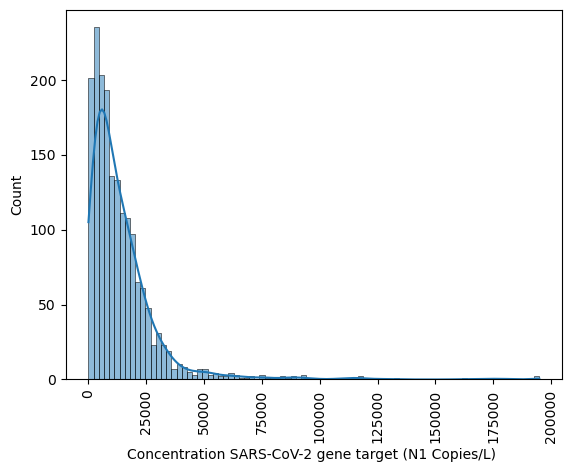

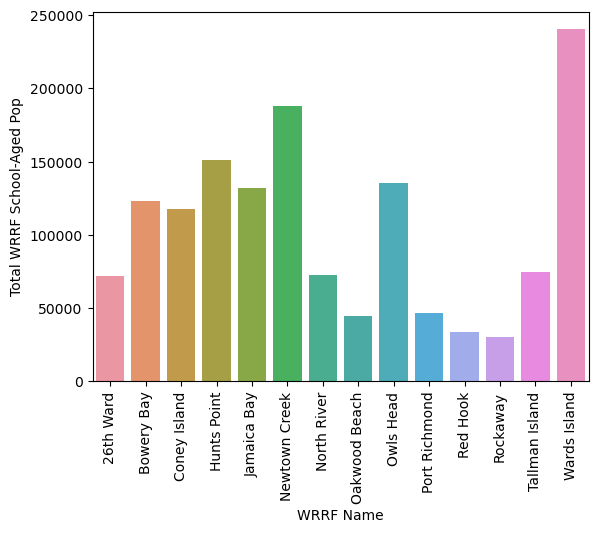

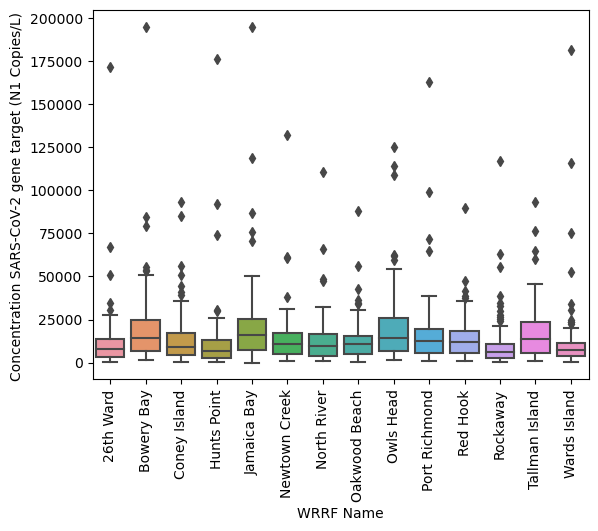

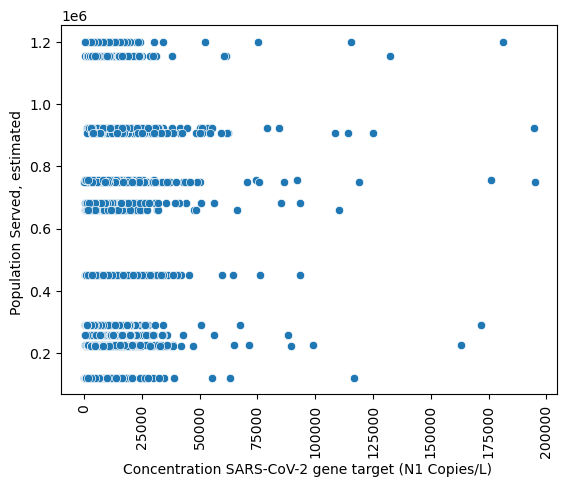

/var/folders/yf/9lmqvqdx2h3d7cgwxqhp7bnc0000gn/T/ipykernel_72374/1072077862.py:23: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = merged_df_post_omi.corr()


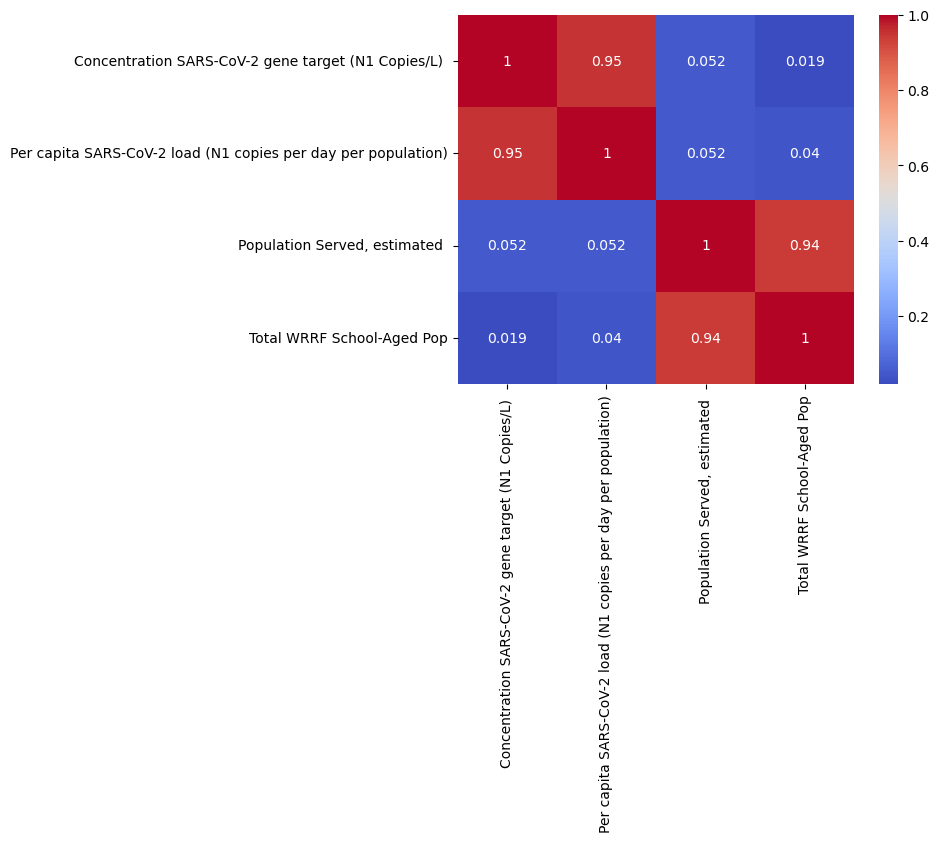

In [5]:
# Few visualizations. We already have a good idea of the general contours of this data and expect it to 
# diverge from pre-omicron


sns.histplot(data=merged_df_post_omi, x='Concentration SARS-CoV-2 gene target (N1 Copies/L) ', kde=True)
plt.xticks(rotation=90)
plt.show()

sns.barplot(data=merged_df_post_omi, x='WRRF Name', y='Total WRRF School-Aged Pop')
plt.xticks(rotation=90)
plt.show()

sns.boxplot(data=merged_df_post_omi, x='WRRF Name', y='Concentration SARS-CoV-2 gene target (N1 Copies/L) ')
plt.xticks(rotation=90)
plt.show()


sns.scatterplot(data=merged_df_post_omi, x='Concentration SARS-CoV-2 gene target (N1 Copies/L) ', y='Population Served, estimated ')
plt.xticks(rotation=90)
plt.show()


corr = merged_df_post_omi.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()




# Modelling Post-Omicron 

In [6]:

# Removing date info since we decided before that it is too over-determining. We are only keeping the School-aged Population info
# from our engineered features, since the others would need to be re-created for this time period.

X = merged_df_post_omi.drop(columns=['Concentration SARS-CoV-2 gene target (N1 Copies/L) ', 'Sample Date'], axis=1)
y = merged_df_post_omi['Concentration SARS-CoV-2 gene target (N1 Copies/L) ']



X_train_2 ,X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.20, random_state=42)

# log transform
y_train_2 = np.log(y_train_2)
y_test_2 = np.log(y_test_2)

In [7]:
# Now, we would like to go back and add in seasons, holidays, etc for this period, but out of curiosity, let's
# see how our model works on just this data. We want to do the same transformations as before, but our features
# are a bit different, so let's account for that.


# Re-doing the columns 
date_cols = []
cat_cols = []  
num_cols = []   

for i in merged_df_post_omi.columns:
    if i == 'Concentration SARS-CoV-2 gene target (N1 Copies/L) ' or i == 'Sample Date':
        pass
    elif merged_df_post_omi[i].dtype == 'object':
        cat_cols.append(i)
    elif merged_df_post_omi[i].dtype == 'float64' or 'int64':
        num_cols.append(i)
    else:
        print("error")
        
class ColumnSelector(BaseEstimator, TransformerMixin): 
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]
    

In [8]:
# Using same prepocessing and parameters as our best pre-Omicron model

cat_preprocessor = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_preprocessor = Pipeline([
    ('selector', ColumnSelector(columns=num_cols)), 
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_preprocessor, cat_cols),
    ('num', numeric_preprocessor, num_cols),
])

grad_2 = GradientBoostingRegressor(criterion='squared_error', learning_rate=0.1, loss='absolute_error', n_estimators=150, subsample=0.5, random_state=42)


grad_2_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',  grad_2)
])

grad_2_pipeline.fit(X_train_2, y_train_2)

y_pred_2 = grad_2_pipeline.predict(X_test_2)

train_score = grad_2_pipeline.score(X_train_2, y_train_2)
print(train_score)

test_score = r2_score(y_test_2, y_pred_2)
print(test_score)

cross_validate(grad_2_pipeline, X_train_2, y_train_2, return_train_score=True)

0.9770427943343455
0.8967371162498574


{'fit_time': array([0.44166994, 0.43716621, 0.43398285, 0.43255496, 0.43614316]),
 'score_time': array([0.00610209, 0.00589395, 0.00627112, 0.00598884, 0.0057857 ]),
 'test_score': array([0.96583797, 0.9796024 , 0.97240629, 0.97136544, 0.91658943]),
 'train_score': array([0.97812871, 0.97436199, 0.97671331, 0.97591404, 0.97802545])}

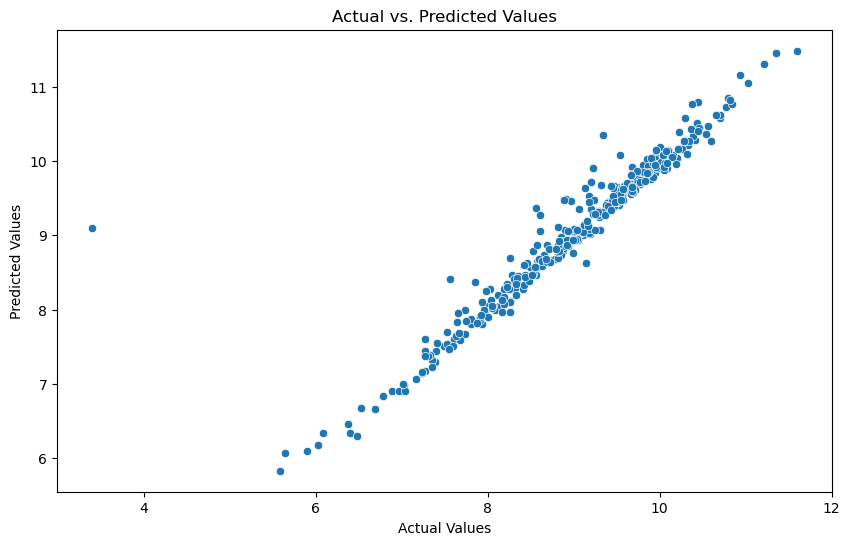

In [9]:
# Not horrible over all!

# Let's visualize! Want to look at real vs predicted values as well as residuals and their distributions


plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_2, y=y_pred_2)
plt.xlabel('Actual Values')


plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

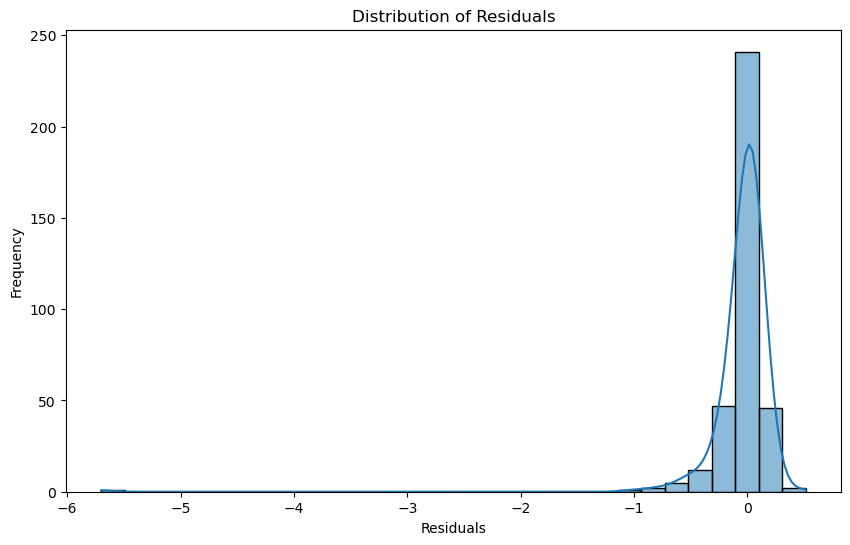

In [10]:
residuals = y_test_2 - y_pred_2

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

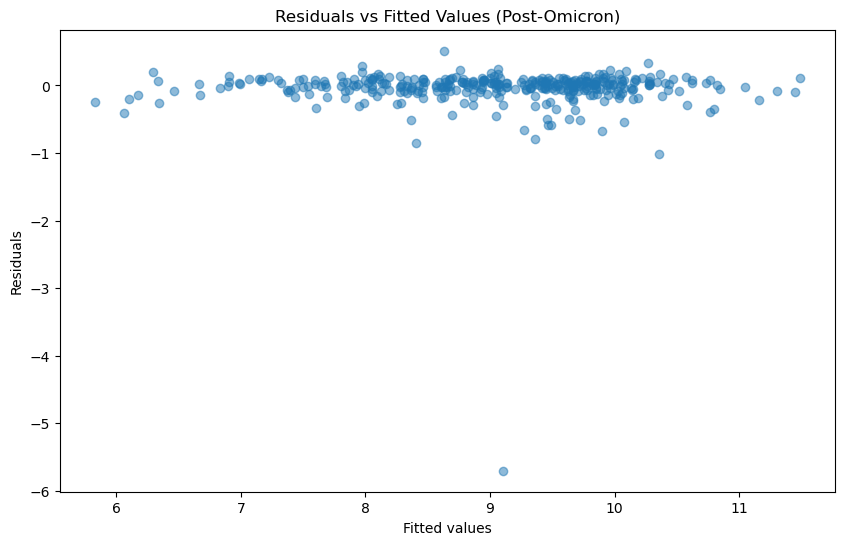

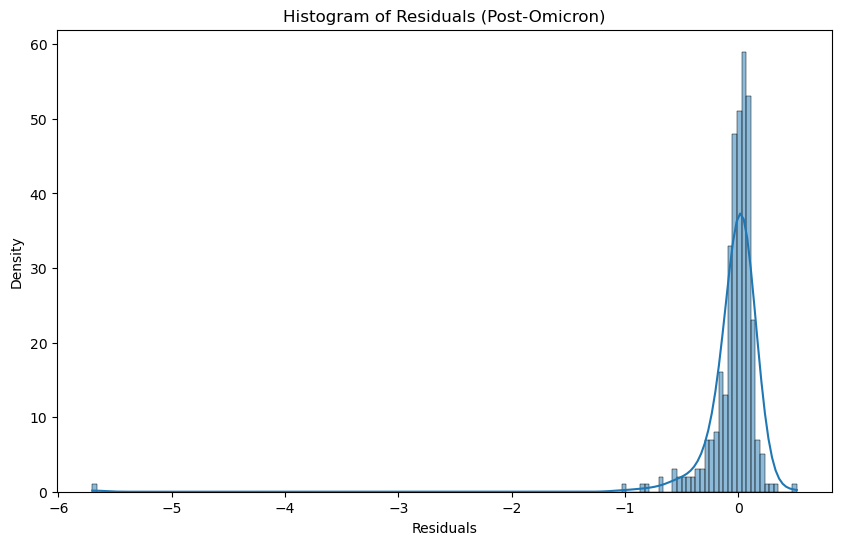

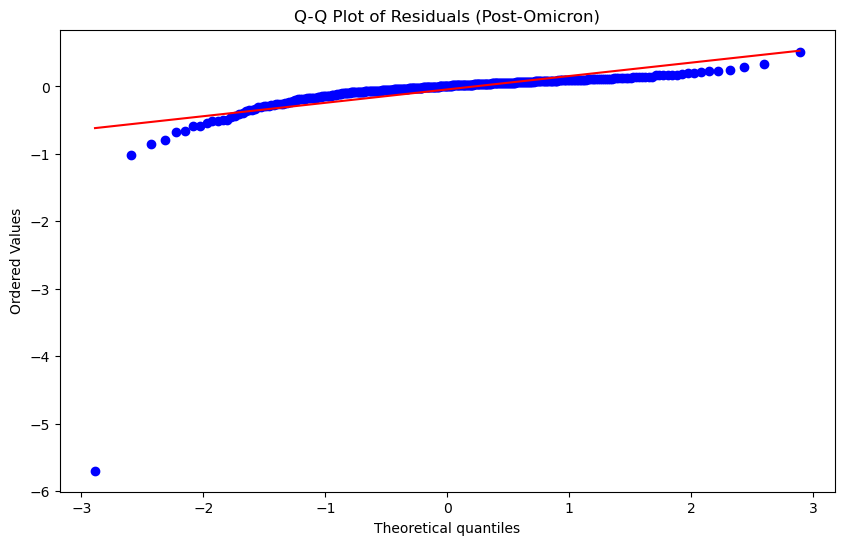

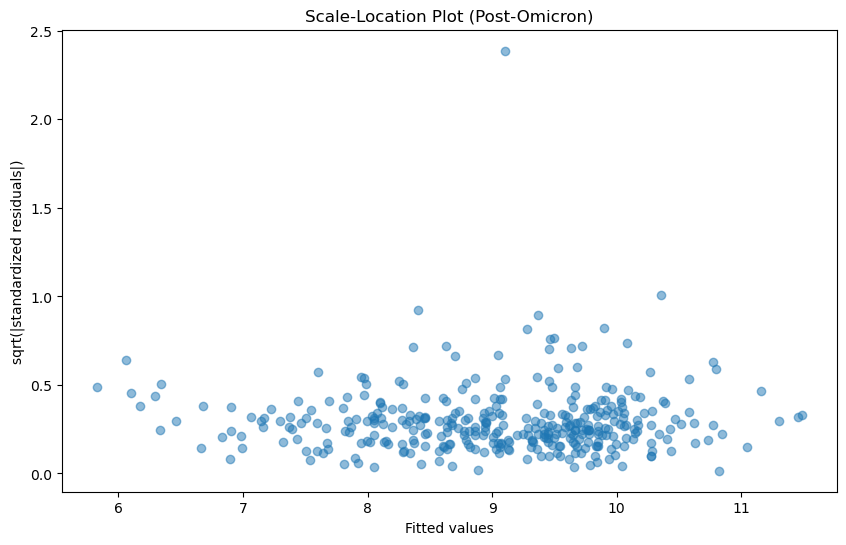

In [11]:
# Whole bunch of plots analyzing residuals. We want to better understand how this model performs on data from
# the post-Omicron period, and how and where it may be overfitting.


# calculate residuals
residuals_2 = y_test_2 - y_pred_2



plt.figure(figsize=(10, 6))
plt.scatter(y_pred_2, residuals_2, alpha=0.5)
plt.title('Residuals vs Fitted Values (Post-Omicron)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(residuals_2, kde=True)
plt.title('Histogram of Residuals (Post-Omicron)')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


plt.figure(figsize=(10, 6))
stats.probplot(residuals_2, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Post-Omicron)')
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(y_pred_2, np.sqrt(np.abs(residuals_2)), alpha=0.5)
plt.title('Scale-Location Plot (Post-Omicron)')
plt.xlabel('Fitted values')
plt.ylabel('sqrt(|standardized residuals|)')
plt.show()


In [12]:
merged_df_post_omi.describe()

,Concentration SARS-CoV-2 gene target (N1 Copies/L),Per capita SARS-CoV-2 load (N1 copies per day per population),"Population Served, estimated",Total WRRF School-Aged Pop
count,1784.000000,1.784000e+03,1.784000e+03,1784.000000
mean,14342.075667,6.887098e+06,6.152026e+05,104419.314462
std,17468.202308,8.251053e+06,3.453580e+05,59955.490409
min,30.000000,0.000000e+00,1.205390e+05,29986.000000
25%,4605.120000,2.362500e+06,2.587310e+05,46435.000000
50%,9905.500000,5.035000e+06,6.823420e+05,117865.000000
75%,18320.500000,8.762500e+06,9.064420e+05,135396.000000
max,194978.000000,1.072989e+08,1.201485e+06,240219.000000


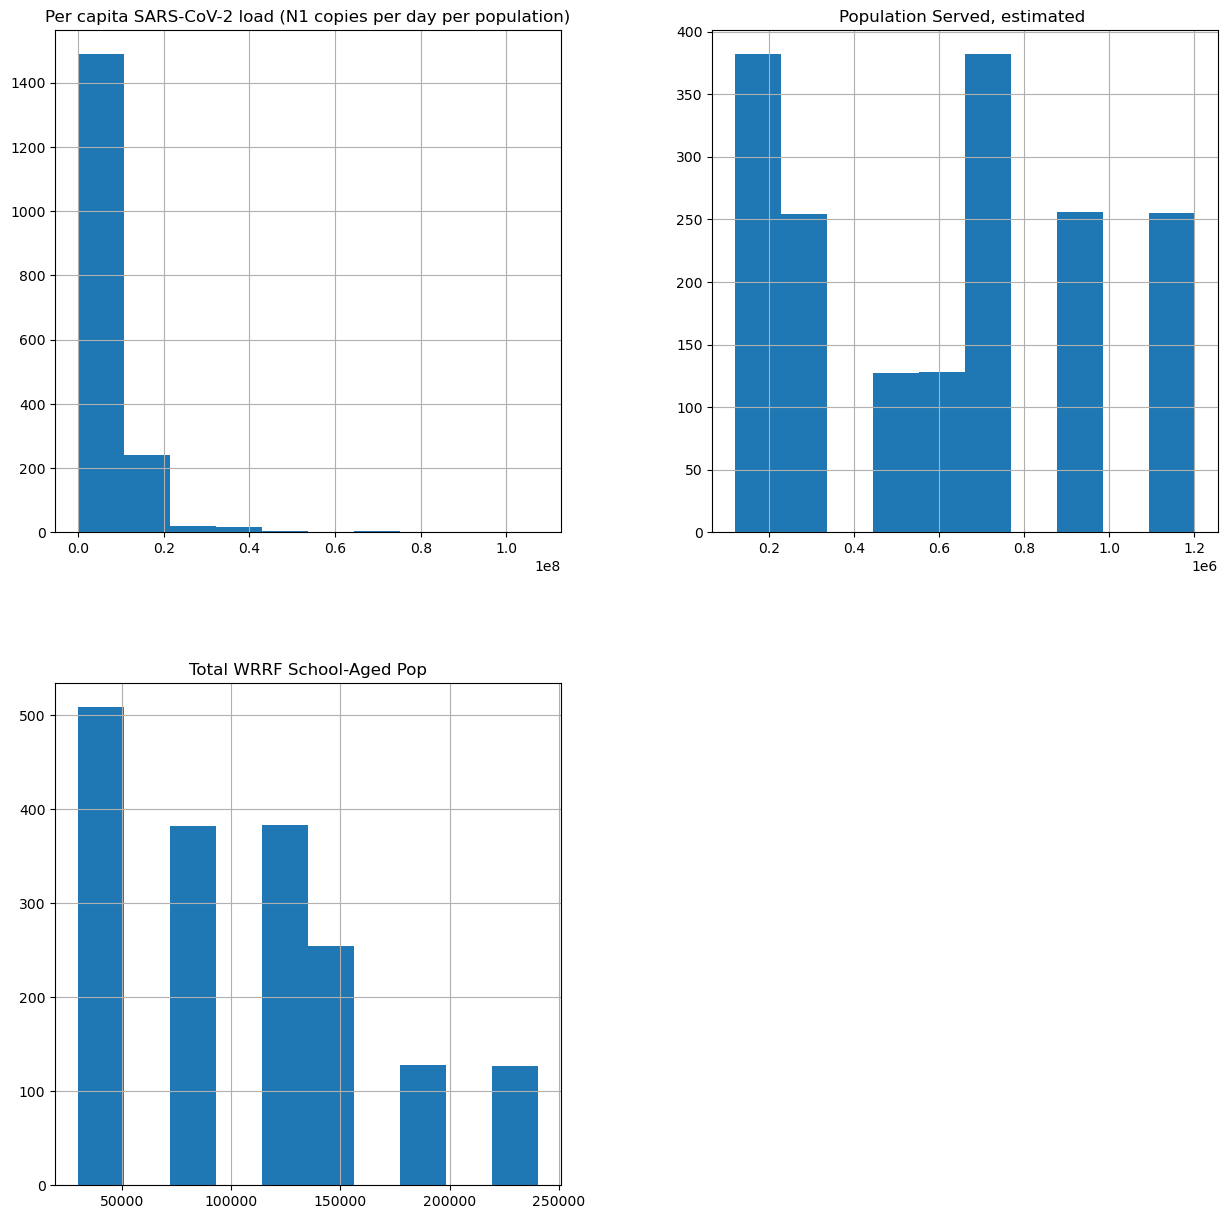

In [14]:
# Let's visualize this some more. We didn't properly address outliers with pre-omicron features. 
copy = merged_df_post_omi.copy()
copy.drop(columns=['Concentration SARS-CoV-2 gene target (N1 Copies/L) ', 'Sample Date'], inplace=True)
copy.hist(figsize = (15,15))
plt.show()

In [15]:
copy.columns

Index(['WRRF Name',
       'Per capita SARS-CoV-2 load (N1 copies per day per population)',
       'Population Served, estimated ', 'Total WRRF School-Aged Pop'],
      dtype='object')

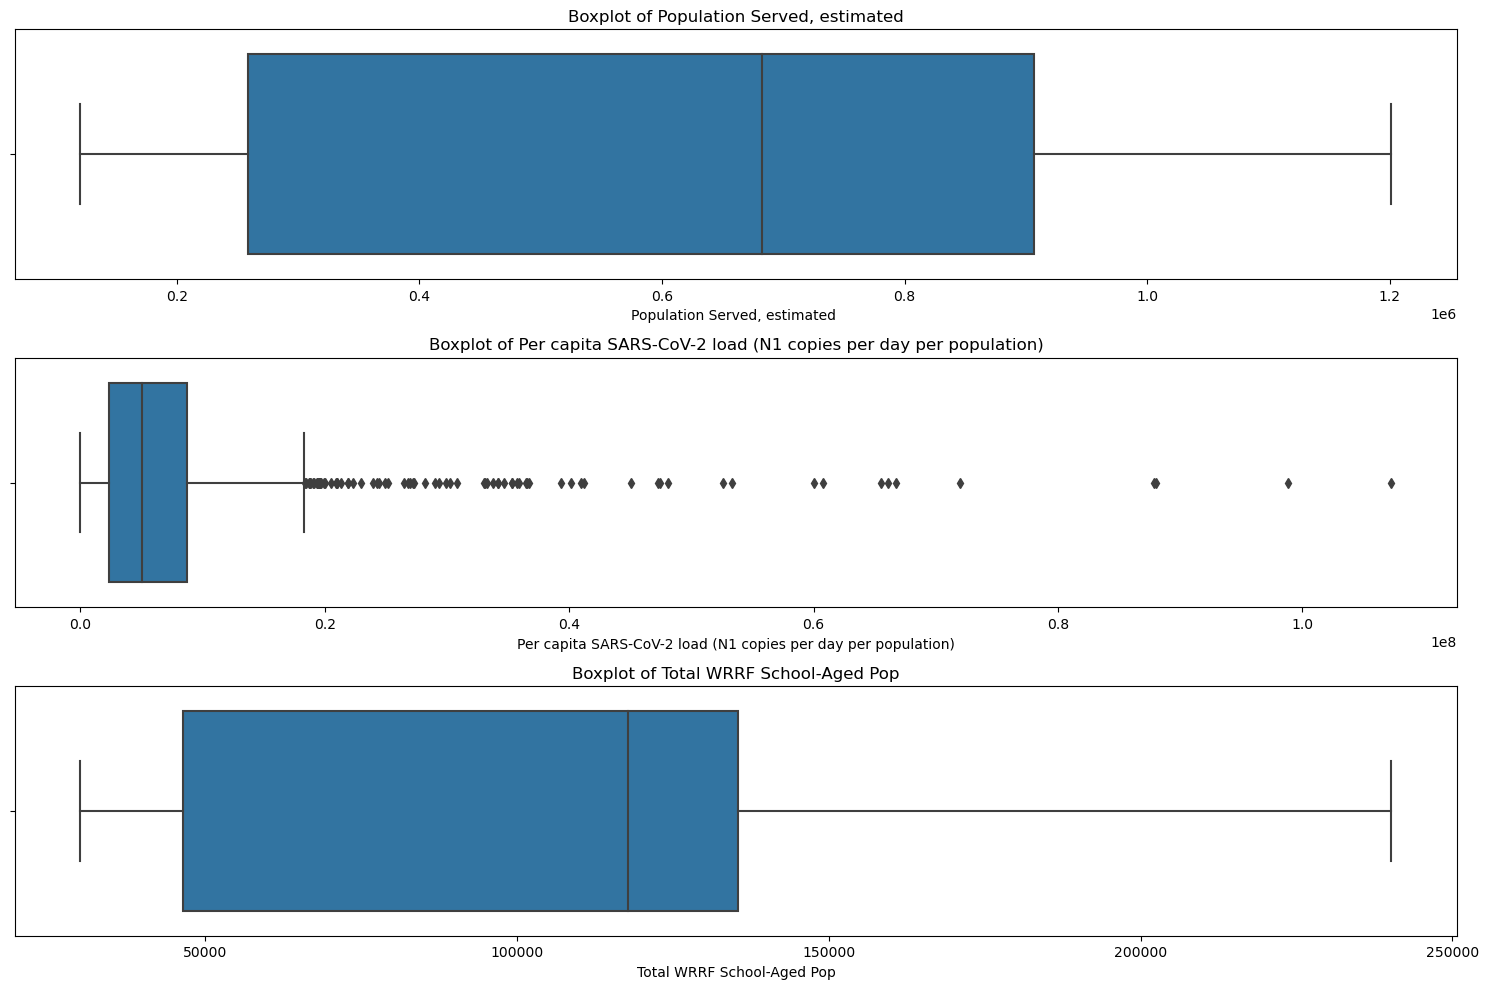

In [19]:
# Defining a function to calculate z-scores and outliers greater than 3 stds
def identify_outliers(df, column):
    z_scores = zscore(df[column])
    df['z_scores'] = z_scores
    outliers = df[(df['z_scores'] > 3) | (df['z_scores'] < -3)]
    return outliers

outliers_1 = identify_outliers(copy, 'Population Served, estimated ')
outliers_2 = identify_outliers(copy, 'Per capita SARS-CoV-2 load (N1 copies per day per population)')
outliers_3 = identify_outliers(copy, 'Total WRRF School-Aged Pop')


plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
sns.boxplot(x=copy['Population Served, estimated '])
plt.title('Boxplot of Population Served, estimated')

plt.subplot(3, 1, 2)
sns.boxplot(x=copy['Per capita SARS-CoV-2 load (N1 copies per day per population)'])
plt.title('Boxplot of Per capita SARS-CoV-2 load (N1 copies per day per population)')

plt.subplot(3, 1, 3)
sns.boxplot(x=copy['Total WRRF School-Aged Pop'])
plt.title('Boxplot of Total WRRF School-Aged Pop')

plt.tight_layout()
plt.show()


In [13]:

# Going to try again using sklearn.preprocessing.RobustScaler. Seems like might be useful given outliers? Especially
# with regards to our per capita feature.


X = merged_df_post_omi.drop(columns=['Concentration SARS-CoV-2 gene target (N1 Copies/L) ', 'Sample Date'], axis=1)
y = merged_df_post_omi['Concentration SARS-CoV-2 gene target (N1 Copies/L) ']



X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# log transform
y_train = np.log(y_train)
y_test = np.log(y_test)

# Re-adjusting data types for preprocessing
cat_cols = []  
num_cols = []   

for i in merged_df_post_omi.columns:
    if i == 'Concentration SARS-CoV-2 gene target (N1 Copies/L) ' or i == 'Holiday' or i == 'Sample Date':
        pass
    elif merged_df_post_omi[i].dtype == 'object':
        cat_cols.append(i)
    elif merged_df_post_omi[i].dtype == 'float64' or merged_df_post_omi[i].dtype == 'int64':
        num_cols.append(i)
    else:
        print("error")
        
print(cat_cols)
print(num_cols)

['WRRF Name']
['Per capita SARS-CoV-2 load (N1 copies per day per population)', 'Population Served, estimated ', 'Total WRRF School-Aged Pop']


In [14]:
# Adjusting preprocessing steps

numeric_preprocessor_2 = Pipeline([
    ('selector', ColumnSelector(columns=num_cols)), 
    ('scaler', RobustScaler())
])

preprocessor_4 = ColumnTransformer([   # This is our 4th preprocesser!
    ('cat', cat_preprocessor, cat_cols),
    ('num', numeric_preprocessor_2, num_cols),
])



# Using our best pre-Omicron model as before

grad_3 = GradientBoostingRegressor(criterion='squared_error', learning_rate=0.1, loss='absolute_error', n_estimators=150, subsample=0.5, random_state=42)
grad_3_pipeline = Pipeline([
    ('preprocessor', preprocessor_4),
    ('model',  grad_3)
])

grad_3_pipeline.fit(X_train, y_train)

y_pred_3 = grad_3_pipeline.predict(X_test)

train_score = grad_3_pipeline.score(X_train, y_train)
print(train_score)

test_score = r2_score(y_test, y_pred_3)
print(test_score)

cross_validate(grad_3_pipeline, X_train, y_train, return_train_score=True)

0.976945548604076
0.8966626484177773


{'fit_time': array([0.4751339 , 0.51294708, 0.5358789 , 0.48822594, 0.49132419]),
 'score_time': array([0.00652504, 0.00701094, 0.00821424, 0.00644612, 0.00678778]),
 'test_score': array([0.96593551, 0.97948115, 0.97195754, 0.97197628, 0.91789946]),
 'train_score': array([0.97739349, 0.97323829, 0.97664909, 0.97616379, 0.97829387])}

In [15]:
# Adjusting preprocessing columns for post-omi

cat_cols = []  
num_cols = []   

for i in merged_df_post_omi.columns:
    if i == 'Concentration SARS-CoV-2 gene target (N1 Copies/L) ':
        pass
    elif merged_df_post_omi[i].dtype == 'object':
        cat_cols.append(i)
    elif i == 'Sample Date':
        pass
    elif merged_df_post_omi[i].dtype == 'float64' or 'int64':
        num_cols.append(i)
    else:
        print("error")
        


In [16]:
# Almost identical test/train scores for RobustScaler, so apparently our outliers are not too extreme.

In [17]:
# What if we just drop the total population served? Let's check out vif scores. 

In [18]:
# Have to rename 'Total WRRF School-Aged Pop' due to conflict with hyphen

merged_df_post_omi.rename({'Total WRRF School-Aged Pop': 'Total WRRF Schoolaged Pop'},axis=1, inplace=True)

merged_df_post_omi.columns = merged_df_post_omi.columns.str.replace(' ', '_', regex=True).str.replace('-', '_', regex=True).str.replace(',', '', regex=True).str.replace('(', '', regex=True).str.replace(')', '', regex=True).str.replace('/', '', regex=True).str.strip()



In [19]:
y, X = dmatrices('Concentration_SARS_CoV_2_gene_target_N1_CopiesL_ ~ Population_Served_estimated_+Total_WRRF_Schoolaged_Pop', data=merged_df_post_omi, return_type='dataframe')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif


,VIF,variable
0,4.210429,Intercept
1,8.927297,Population_Served_estimated_
2,8.927297,Total_WRRF_Schoolaged_Pop


In [20]:
# Alright, very high VIFs, bud still don't want to removee this data. Would be nice to break it down by age groups within
# school-age children as we originally sourced.

# Feature Engineering for Post-Omicron

In [21]:
# Have to reset index to date to match it against holidays
merged_df_post_omi.set_index('Sample_Date', inplace=True)

In [22]:
# Holidays: Federal US Holidays


us_holidays = holidays.UnitedStates(years=[2021, 2022, 2023])

def is_holiday(date):
    return date in us_holidays




In [23]:
# Holidays: Jewish Holidays 

# Major Jewish Holidays, 2021
us_holidays[datetime.date(2021, 11, 28)] = 'Chanukah'
us_holidays[datetime.date(2021, 11, 29)] = 'Chanukah'
us_holidays[datetime.date(2021, 11, 30)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 1)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 2)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 3)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 4)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 5)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 6)] = 'Chanukah'

# Major Jewish Holidays, 2022
us_holidays[datetime.date(2022, 3, 16)] = 'Purim'
us_holidays[datetime.date(2022, 3, 17)] = 'Purim'
us_holidays[datetime.date(2022, 4, 15)] = 'Passover'
us_holidays[datetime.date(2022, 4, 16)] = 'Passover'
us_holidays[datetime.date(2022, 4, 17)] = 'Passover'
us_holidays[datetime.date(2022, 4, 18)] = 'Passover'
us_holidays[datetime.date(2022, 4, 19)] = 'Passover'
us_holidays[datetime.date(2022, 4, 20)] = 'Passover'
us_holidays[datetime.date(2022, 4, 21)] = 'Passover'
us_holidays[datetime.date(2022, 4, 22)] = 'Passover'
us_holidays[datetime.date(2022, 4, 23)] = 'Passover'
us_holidays[datetime.date(2022, 6, 4)] = 'Shauvot'
us_holidays[datetime.date(2022, 6, 5)] = 'Shauvot'
us_holidays[datetime.date(2022, 6, 6)] = 'Shauvot'
us_holidays[datetime.date(2022, 9, 25)] = 'Rosh Hashanah'
us_holidays[datetime.date(2022, 9, 26)] = 'Rosh Hashanah'
us_holidays[datetime.date(2022, 9, 27)] = 'Rosh Hashanah'
us_holidays[datetime.date(2022, 10, 4)] = 'Yom Kippur'
us_holidays[datetime.date(2022, 10, 5)] = 'Yom Kippur'
us_holidays[datetime.date(2022, 10, 9)] = 'Sukkot'
us_holidays[datetime.date(2022, 10, 10)] = 'Sukkot'
us_holidays[datetime.date(2022, 10, 11)] = 'Sukkot'
us_holidays[datetime.date(2022, 10, 12)] = 'Sukkot'
us_holidays[datetime.date(2022, 10, 13)] = 'Sukkot'
us_holidays[datetime.date(2022, 10, 14)] = 'Sukkot'
us_holidays[datetime.date(2022, 10, 15)] = 'Sukkot'
us_holidays[datetime.date(2022, 10, 16)] = 'Sukkot'
us_holidays[datetime.date(2022, 12, 18)] = 'Chanukah'
us_holidays[datetime.date(2022, 12, 19)] = 'Chanukah'
us_holidays[datetime.date(2022, 12, 20)] = 'Chanukah'
us_holidays[datetime.date(2022, 12, 21)] = 'Chanukah'
us_holidays[datetime.date(2022, 12, 22)] = 'Chanukah'
us_holidays[datetime.date(2022, 12, 23)] = 'Chanukah'
us_holidays[datetime.date(2022, 12, 24)] = 'Chanukah'
us_holidays[datetime.date(2022, 12, 25)] = 'Chanukah'
us_holidays[datetime.date(2022, 12, 26)] = 'Chanukah'


# Major Jewish holidays, 2023
us_holidays[datetime.date(2023, 3, 6)] = 'Purim'
us_holidays[datetime.date(2023, 3, 7)] = 'Purim'
us_holidays[datetime.date(2023, 4, 5)] = 'Passover'
us_holidays[datetime.date(2023, 4, 6)] = 'Passover'
us_holidays[datetime.date(2023, 4, 7)] = 'Passover'
us_holidays[datetime.date(2023, 4, 8)] = 'Passover'
us_holidays[datetime.date(2023, 4, 9)] = 'Passover'
us_holidays[datetime.date(2023, 4, 10)] = 'Passover'
us_holidays[datetime.date(2023, 4, 11)] = 'Passover'
us_holidays[datetime.date(2023, 4, 12)] = 'Passover'
us_holidays[datetime.date(2023, 4, 13)] = 'Passover'


In [24]:
# unsure how 1970 got in there, but our filter will filter out anything not in our date range
merged_df_post_omi['Holiday'] = merged_df_post_omi.index.map(is_holiday).astype(int)


In [25]:
merged_df_post_omi['Holiday'].value_counts()

0    1546
1     238
Name: Holiday, dtype: int64

In [26]:
# Let's add seasons again. Keeping the index for now

def get_season(date):
    if date.strftime('%Y-%m-%d') >= '2021-03-20' and date.strftime('%Y-%m-%d') <= '2021-06-19':
        return 'Spring 2021'
    elif date.strftime('%Y-%m-%d') >= '2021-06-20' and date.strftime('%Y-%m-%d') <= '2021-09-21':
        return 'Summer 2021'
    elif date.strftime('%Y-%m-%d') >= '2021-09-22' and date.strftime('%Y-%m-%d') <= '2021-12-20':
        return 'Fall 2021'
    elif date.strftime('%Y-%m-%d') >= '2021-12-21' and date.strftime('%Y-%m-%d') <= '2022-03-19':
        return 'Winter 2021'
    elif date.strftime('%Y-%m-%d') >= '2022-03-20' and date.strftime('%Y-%m-%d') <= '2022-06-19':
        return 'Spring 2022'
    elif date.strftime('%Y-%m-%d') >= '2022-06-20' and date.strftime('%Y-%m-%d') <= '2022-09-21':
        return 'Summer 2022'
    elif date.strftime('%Y-%m-%d') >= '2022-09-22' and date.strftime('%Y-%m-%d') <= '2022-12-20':
        return 'Fall 2022'
    elif date.strftime('%Y-%m-%d') >= '2022-12-21' and date.strftime('%Y-%m-%d') <= '2023-03-19':
        return 'Winter 2022'
    elif date.strftime('%Y-%m-%d') >= '2023-03-20' and date.strftime('%Y-%m-%d') <= '2023-06-19':
        return 'Spring 2023'
    elif date.strftime('%Y-%m-%d') >= '2023-06-20' and date.strftime('%Y-%m-%d') <= '2023-09-21':
        return 'Summer 2023'
    else: 
        return 'Fall 2023'


merged_df_post_omi['Season'] = merged_df_post_omi.index.map(get_season)

merged_df_post_omi.sample(5)

,WRRF_Name,Concentration_SARS_CoV_2_gene_target_N1_CopiesL_,Per_capita_SARS_CoV_2_load_N1_copies_per_day_per_population,Population_Served_estimated_,Total_WRRF_Schoolaged_Pop,Holiday,Season
Sample_Date,,,,,,,
2022-11-28,Oakwood Beach,26986.0,9790000.0,258731,44374.0,0,Fall 2022
2022-08-07,Port Richmond,13941.0,5600000.0,226167,46435.0,0,Summer 2022
2022-09-11,Tallman Island,9680.0,6030000.0,449907,74748.0,0,Summer 2022
2022-08-28,North River,5052.0,2930000.0,658596,72242.0,0,Summer 2022
2022-08-30,Tallman Island,20912.0,10000000.0,449907,74748.0,0,Summer 2022


In [27]:
# Now that we've got our seasons and holidays, let's reset the index and make "Sample Date" a column.

merged_df_post_omi.reset_index(inplace=True)


In [28]:
# Only thing left to add is school events, which in this case would just be normal school schedules and which
# would map closely to seasons. Let's leave that category out.

# Let's rename columns before saving our post-omicron data.  

merged_df_post_omi.rename(columns={
    'Concentration_SARS_CoV_2_gene_target_N1_CopiesL_': 'Gene Copies (N1/L)',
    'Per_capita_SARS_CoV_2_load_N1_copies_per_day_per_population': 'Per Capita Gene Copies',
    'Population_Served_estimated_': 'Population Served, estimated',
    'Total_WRRF_Schoolaged_Pop': 'School-Aged Population'}, inplace=True)

# merged_df_post_omi.to_csv('data/post_omi.csv', index=False)


In [29]:
# Post-Omicron Modelling with More Engineered Features

post_omi_df = pd.read_csv('data/post_omi.csv')
post_omi_df.sample(5)
post_omi_df['Sample_Date'] = pd.to_datetime(post_omi_df['Sample_Date'])

In [30]:
post_omi_df

,Sample_Date,WRRF_Name,Gene Copies (N1/L),Per Capita Gene Copies,"Population Served, estimated",School-Aged Population,Season,Holiday
0,2021-11-02,26th Ward,6506.0,4152389.80,290608,72091.0,Fall 2021,0
1,2021-11-02,Bowery Bay,4735.0,1705896.00,924695,122994.0,Fall 2021,0
2,2021-11-02,Coney Island,2185.0,994063.38,682342,117865.0,Fall 2021,0
3,2021-11-02,Hunts Point,2340.0,1358955.77,755948,151282.0,Fall 2021,0
4,2021-11-02,Jamaica Bay,3547.0,1416723.60,748737,131881.0,Fall 2021,0
...,...,...,...,...,...,...,...,...
1779,2023-04-11,Port Richmond,4616.0,1850000.00,226167,46435.0,Spring 2023,1
1780,2023-04-11,Red Hook,4726.0,2080000.00,224029,33636.0,Spring 2023,1
1781,2023-04-11,Rockaway,1697.0,906000.00,120539,29986.0,Spring 2023,1
1782,2023-04-11,Tallman Island,3340.0,1210000.00,449907,74748.0,Spring 2023,1


In [31]:
date_cols = []
cat_cols = []  
num_cols = []   

for i in post_omi_df.columns:
    if i == 'Gene Copies (N1/L)' or i == 'Holiday':
        pass 
    elif post_omi_df[i].dtype == 'object':
        cat_cols.append(i)
    elif post_omi_df[i].dtype == 'datetime64[ns]':
        date_cols.append(i)
    elif post_omi_df[i].dtype == 'float64' or merged_df_post_omi[i].dtype == 'int64':
        num_cols.append(i)
    else:
        print("error")
        
print(date_cols)
print(cat_cols)
print(num_cols)

['Sample_Date']
['WRRF_Name', 'Season']
['Per Capita Gene Copies', 'Population Served, estimated', 'School-Aged Population']


In [32]:
y = post_omi_df ['Gene Copies (N1/L)']

X = post_omi_df.drop('Gene Copies (N1/L)', axis=1)

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)


In [33]:
cat_preprocessor = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_preprocessor = Pipeline([
    ('selector', ColumnSelector(columns=num_cols)), 
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_preprocessor, cat_cols),
    ('num', numeric_preprocessor, num_cols),
])

grad_2 = GradientBoostingRegressor(criterion='squared_error', learning_rate=0.1, loss='absolute_error', n_estimators=250, subsample=0.7, random_state=42)


grad_2_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',  grad_2)
])

grad_2_pipeline.fit(X_train, y_train)

y_pred = grad_2_pipeline.predict(X_test)

train_score = grad_2_pipeline.score(X_train, y_train)
print(train_score)

test_score = r2_score(y_test, y_pred)
print(test_score)

0.9792571769922698
0.921550615396309


In [34]:
grad_model = grad_2_pipeline.named_steps['model']
features = []
scores = []
# Print the coefficients along with column names
for feature_name, importance in zip(X.columns, grad_model.feature_importances_):
    features.append(feature_name)
    scores.append(importance)
    
ranked_scores = sorted(zip(scores, features), reverse=True)
for score, feature in ranked_scores:
    print(f'{score}: {feature}')

0.0403404815057108: Sample_Date
0.03943598557669468: Holiday
0.016353311099042082: School-Aged Population
0.01299496753653493: WRRF_Name
0.007166387271874707: Population Served, estimated
0.004805252451630923: Season
0.0022261181978062232: Per Capita Gene Copies


In [35]:
# Let's drop date info as before.

y = post_omi_df ['Gene Copies (N1/L)']

X = post_omi_df.drop(columns=['Gene Copies (N1/L)', 'Sample_Date'], axis=1)

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)

In [36]:
cat_preprocessor = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_preprocessor = Pipeline([
    ('selector', ColumnSelector(columns=num_cols)), 
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_preprocessor, cat_cols),
    ('num', numeric_preprocessor, num_cols),
])

grad_2 = GradientBoostingRegressor(criterion='squared_error', learning_rate=0.1, loss='absolute_error', n_estimators=150, subsample=0.5, random_state=42)


grad_2_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',  grad_2)
])

grad_2_pipeline.fit(X_train, y_train)

y_pred = grad_2_pipeline.predict(X_test)

train_score = grad_2_pipeline.score(X_train, y_train)
print(train_score)

test_score = r2_score(y_test, y_pred)
print(test_score)

0.9775790817147073
0.9226426424514184


In [37]:
grad_model = grad_2_pipeline.named_steps['model']
features = []
scores = []
# Print the coefficients along with column names
for feature_name, importance in zip(X.columns, grad_model.feature_importances_):
    features.append(feature_name)
    scores.append(importance)
    
ranked_scores = sorted(zip(scores, features), reverse=True)
for score, feature in ranked_scores:
    print(f'{score}: {feature}')

0.04186005296729049: WRRF_Name
0.01437212568584682: Season
0.010258085107429012: Per Capita Gene Copies
0.0066794820202109835: Holiday
0.004935402389601626: School-Aged Population
0.0007449077153210352: Population Served, estimated


In [38]:
# Once more without Per Capita Gene Copies (daily) and Population Served, which tend towards colinearity. 

In [39]:
y = post_omi_df ['Gene Copies (N1/L)']

X = post_omi_df.drop(columns=['Gene Copies (N1/L)', 'Sample_Date', 'Per Capita Gene Copies', 'Population Served, estimated'], axis=1)

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)

In [40]:
# Adding holidays and seasons gave us a slight boost on our test scores, but these features are not as important
# as with pre-omicron data. Clearly there are many other factors here that we are not accounting for. We assume the majoy missing variable is the average immunity 
# (antibody duration in particular). Would also like to factor in office re-openings, changes in municipal, state, 
# and federal policies, etc.

In [41]:
date_cols = []
cat_cols = []  
num_cols = []   


num_cols = []   

for i in post_omi_df.columns:
    if i == 'Gene Copies (N1/L)' or i == 'Holiday' or i == 'Per Capita Gene Copies' or i == 'Population Served, estimated':
        pass 
    elif post_omi_df[i].dtype == 'object':
        cat_cols.append(i)
    elif post_omi_df[i].dtype == 'datetime64[ns]':
        date_cols.append(i)
    elif post_omi_df[i].dtype == 'float64' or merged_df_post_omi[i].dtype == 'int64':
        num_cols.append(i)
    else:
        print("error")
        
print(date_cols)
print(cat_cols)
print(num_cols)

['Sample_Date']
['WRRF_Name', 'Season']
['School-Aged Population']


In [42]:
cat_preprocessor = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_preprocessor = Pipeline([
    ('selector', ColumnSelector(columns=num_cols)), 
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_preprocessor, cat_cols),
    ('num', numeric_preprocessor, num_cols),
])

grad_2 = GradientBoostingRegressor(criterion='squared_error', learning_rate=0.1, loss='absolute_error', n_estimators=150, subsample=0.5, random_state=42)


grad_2_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',  grad_2)
])

grad_2_pipeline.fit(X_train, y_train)

y_pred = grad_2_pipeline.predict(X_test)

train_score = grad_2_pipeline.score(X_train, y_train)
print(train_score)

test_score = r2_score(y_test, y_pred)
print(test_score)

0.21868701600462104
0.22431025063267285


In [43]:
grad_model = grad_2_pipeline.named_steps['model']
features = []
scores = []
# Print the coefficients along with column names
for feature_name, importance in zip(X.columns, grad_model.feature_importances_):
    features.append(feature_name)
    scores.append(importance)
    
ranked_scores = sorted(zip(scores, features), reverse=True)
for score, feature in ranked_scores:
    print(f'{score}: {feature}')

0.029346903575089206: WRRF_Name
0.02893346979770966: Holiday
0.028000393386142745: School-Aged Population
0.012760344393510042: Season


In [44]:
# This modelled data is quite weak. The variables that were important for pre-Omicron are clearly quite different than 
# with post-Omicron data.

# Run a grid search. 

# Look at kendalltau scores, rankdata, etc.